# Neural Style Transfer

Neural Style Transfer (NST) is one of the most fun techniques in deep learning. As seen below, it merges two images, namely: a **"content" image (C) and a "style" image (S), to create a "generated" image (G**). 

The generated image G combines the "content" of the image C with the "style" of image S. 


In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
%matplotlib inline
np.random.seed(7)

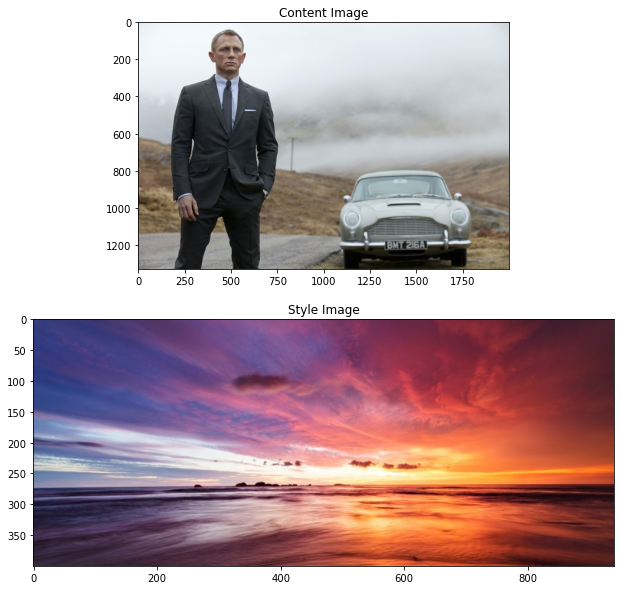

In [11]:
content_img = plt.imread('images/daniel-craig-james-bond.jpg')
style_img = plt.imread('images/sunset.jpg')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))
ax1.imshow(content_img)
ax1.set_title('Content Image')
ax2.imshow(style_img)
ax2.set_title('Style Image')
plt.show()

In [15]:
print("shape of content image :- {}".format(content_img.shape))

shape of content image :- (1333, 2000, 3)


In [16]:
print("shape of content image :- {}".format(style_img.shape))

shape of content image :- (400, 940, 3)


In [18]:
def image2array(image, dims):
    """
    Input: An image. 
    
    Output: The value of each pixel in an array form.
    """
    image = plt.imread(image)
    img = tf.image.convert_image_dtype(image, tf.float32)
    img = tf.image.resize(img, dims)
      # Shape -> (batch_size, h, w, d)
    img = img[tf.newaxis, :]
    return img    

In [19]:
dims = [224, 224]
content_img = image2array('images/daniel-craig-james-bond.jpg', dims)
style_img = image2array('images/sunset.jpg', dims)
content_img.shape, style_img.shape

(TensorShape([1, 224, 224, 3]), TensorShape([1, 224, 224, 3]))

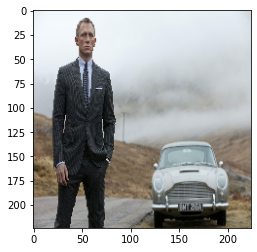

In [22]:
plt.imshow(tf.reshape(content_img, [dims[0], dims[1], 3]))

# Transfer Learning

Neural Style Transfer (NST) uses a previously trained convolutional network, and builds on top of that. The idea of using a network trained on a different task and applying it to a new task is called transfer learning. 

Following the [original NST paper](https://arxiv.org/abs/1508.06576), we will use the VGG network. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low level features (at the shallower layers) and high level features (at the deeper layers). 

In [23]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

In [24]:
for layers in vgg.layers:
    layers.trainable = False

In [52]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [25]:
# Getting VGG19's layers names.
for i in vgg.layers:
    print(i.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [41]:
content_layers = ['block4_conv2'] # Layers to use for content image

style_layers = [ # Layers to use for style image
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [42]:
def get_model(layers_name, model):
    """
    layers_name and model: Layers we want to have in our get_model. We take these layers from the second argument, model where 
    model is a pre-built model.
    Define Our models input and output layers and 
    """
    outputs = [model.get_layer(name).output for name in layers_name]# Collecting all the layers we want to have in our get_model.
    model = Model([vgg.input], outputs)# Defining our get_models input and output layers.
    
    return model

In [43]:
content_img.shape

TensorShape([1, 224, 224, 3])

In [44]:
def gram_matrix(tensor):
    """
    """
    temp = tensor
    temp = tf.squeeze(temp)
    matmul = tf.matmul(temp, temp, transpose_b=True)
    gram = tf.expand_dims(matmul, axis=0)
    
    return gram

In [45]:
class CustomModel(tf.keras.Model): # Creating a class for our Neural Style Model
    
    def __init__(self, style_layers, content_layers): # Passing the layers we want to have in our model
        super(CustomModel, self).__init__()
        self.vgg = get_model(style_layers + content_layers, vgg)
        self.style_layers = style_layers
        self.content_layers = content_layers
        num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        # Rescaling the image 
        inputs = inputs * 255.0
        # Preprocessing it with respect to the VGG19 stats
        preprocessed_inputs = preprocess_input(inputs)
        # 
        outputs = self.vgg(preprocessed_inputs)
        # Separating style and content outputs
        style_outputs = outputs[:num_style_layers]
        content_outputs = outputs[num_style_layers:]
        
        #Calculate the gram matrix for each layer:
        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
        
        # Content representation
        content_dict = {content_name:value
                       for content_name, value in
                       zip(self.content_layers, content_outputs)}
        # Gram Matrix
        style_dict = {style_name:value
                     for style_name, value in
                     zip(style_layers, style_outputs)}
        
        return {'content':content_dict, 'style':style_dict}
        
        

In [46]:
extractor = CustomModel(style_layers, content_layers)
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

In [47]:
optimizer = tf.optimizers.Adam(learning_rate=0.02)

In [48]:
style_weight = 80
content_weight = 30

style_weights = {
    'block1_conv1':1.0,
    'block2_conv1':0.8,
    'block3_conv1':0.5,
    'block4_conv1':0.3,
    'block5_conv1':0.1
}

In [49]:
def total_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    style_loss = tf.add_n([style_weights[name]*tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                          for name in style_outputs.keys()])
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                            for name in content_outputs.keys()])
    
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [50]:
def train_step(image):
    with tf.GradientTape() as tape:
        #extracting the features:
        outputs = extractor(image)
        # Calculate the loss
        loss = total_loss(outputs)
        # Determine the gradients of the loss function w.r.t the image pixels
        grad = tape.gradient(loss, image)
        # Update the pixels
        optimizer.apply_gradients([(grad, image)])
        # Clip the pixel values that fall outside the range of [0,1]
        image.assign(tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0))

In [51]:
target_image = tf.Variable(content_img)

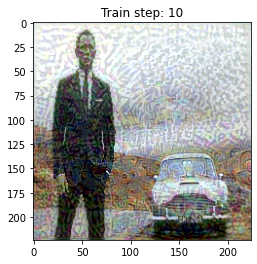

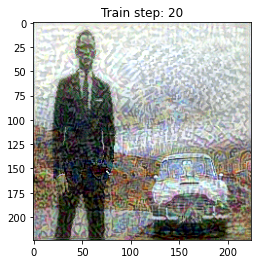

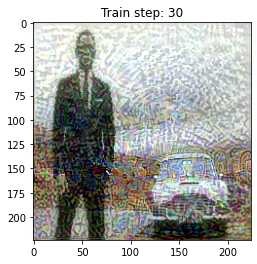

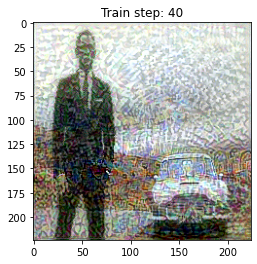

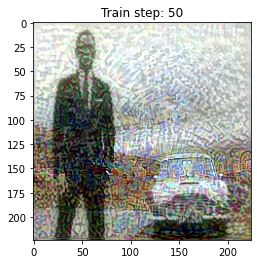

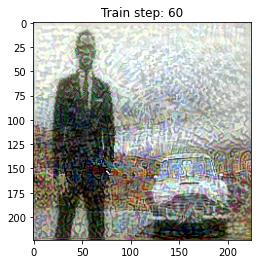

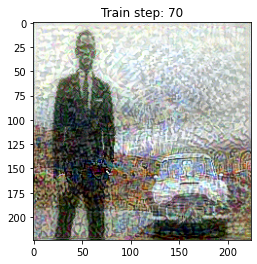

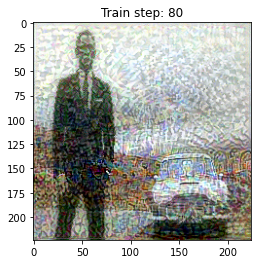

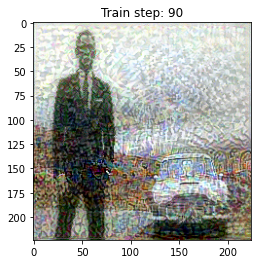

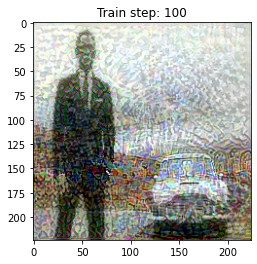

In [52]:
epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(target_image)
    plt.imshow(np.squeeze(target_image.read_value(), 0))
    plt.title("Train step: {}".format(step))
    plt.show()